# 1 Preamble

In [1]:
import numpy as np
import random

import matplotlib.image as mpimg
import seaborn as sns

In [2]:
TYPE_STATE = ['normal', 'stone', 'gem', 'hole', 'boat']
ACTIONS = ['up', 'down', 'left', 'right']
ACTIONSYMBOLS = {'up': "↑", 'down': "↓", 'left': "←", 'right': "→", '':''}

PIRATEIMAGE = mpimg.imread('PirateEnv2.png') 

# 2 Environment

In [3]:
EnvPirate = np.full((6,6), 'normal')

# Complete the Environment !!!

![PirateEnvironment.png](PirateEnv.png)

In [4]:
EnvPirate

array([['normal', 'normal', 'normal', 'normal', 'normal', 'normal'],
       ['normal', 'hole', 'boat', 'normal', 'stone', 'stone'],
       ['normal', 'normal', 'stone', 'normal', 'normal', 'normal'],
       ['boat', 'normal', 'hole', 'hole', 'hole', 'normal'],
       ['normal', 'normal', 'hole', 'normal', 'normal', 'normal'],
       ['gem', 'boat', 'normal', 'normal', 'boat', 'gem']], dtype='<U6')

# 3 Dynamic environment

We determine the next state and reward given the current state and action.

In [5]:
def NextStateAndReward(Position, Action, Rewards={'Tired':0, 'Stone':0, 'Gem':1, 'Hole':-1, 'boat':0}, Environment=EnvPirate):

    Worldsize = Environment.shape

    # If we we are in a boatort
    if Environment[Position] == 'boat':
        if Position == (1,2):
            NextPosition = (4,3)
            Reward = Rewards['Tired']
        elif Position == (3,0):
            NextPosition = (5,3)
            Reward = Rewards['Tired']
        elif Position == (5,1):
            NextPosition = (0,5)
            Reward = Rewards['Tired']
        elif Position == (5,4):
            NextPosition = (0,5)
            Reward = Rewards['Tired']
    else:
        # We select the next position according to the action taken
        if Action == 'up':
            NextPosition = (Position[0]-1, Position[1])
        elif Action == 'down':
            NextPosition = (Position[0]+1, Position[1])
        elif Action == 'left':
            NextPosition = (Position[0], Position[1]-1)
        else:
            NextPosition = (Position[0], Position[1]+1)

        # We check if the next state is inside the grid world, if it is not, then we stay in the same state
        if(
            NextPosition[0] >= 0
            and NextPosition[0] <= Worldsize[0] -1
            and NextPosition[1] >= 0
            and NextPosition[1] <= Worldsize[1] -1
            ):
            # We check the type of state that is the next state
            if Environment[NextPosition] == 'normal':
                Reward = Rewards['Tired']
            elif Environment[NextPosition] == 'stone':
                Reward = Rewards['Stone']
                NextPosition = Position
            elif Environment[NextPosition] == 'boat':
                Reward = Rewards['boat']
            elif Environment[NextPosition] == 'gem':
                Reward = Rewards['Gem']
            elif Environment[NextPosition] == 'hole':
                Reward = Rewards['Hole']
        else:
            NextPosition = Position
            Reward = Rewards['Tired']
    
    return (NextPosition, Reward)

## 3.1 Stochastic environment

If there is slippery floor, the next action is stochastic.

In [6]:
SlipperyOpposite = {
    'up': {'up':0.8, 'down':0.2, 'left':0, 'right':0},
    'down': {'up':0.2, 'down':0.8, 'left':0, 'right':0},
    'left': {'up':0, 'down':0, 'left':0.8, 'right':0.2},
    'right': {'up':0, 'down':0, 'left':0.2, 'right':0.8}
}

SlipperyRandom = {
    'up': {'up':0.8, 'down':0.2/3, 'left':0.2/3, 'right':0.2/3},
    'down': {'up':0.2/3, 'down':0.8, 'left':0.2/3, 'right':0.2/3},
    'left': {'up':0.2/3, 'down':0.2/3, 'left':0.8, 'right':0.2/3},
    'right': {'up':0.2/3, 'down':0.2/3, 'left':0.2/3, 'right':0.8}
}

SlipperyRandomNotOpposite = {
    'up': {'up':0.8, 'down':0, 'left':0.1, 'right':0.1},
    'down': {'up':0, 'down':0.8, 'left':0.1, 'right':0.1},
    'left': {'up':0.1, 'down':0.1, 'left':0.8, 'right':0},
    'right': {'up':0.1, 'down':0.1, 'left':0, 'right':0.8}
}

_ = {'up':0.25, 'down':0.25, 'left':0.25, 'right':0.25}
SlipperyCompletelyRandom = {'up': _, 'down': _, 'left': _, 'right': _}

# 4 Iterative state-action value evaluation

In [7]:
def PlotPolicyValue(Policy, Value, DeterministicPolicy=True):
    if DeterministicPolicy:
        Aux = sns.heatmap(
        Value,
        annot=np.vectorize(ACTIONSYMBOLS.get)(Policy),
        fmt = '',
        cmap='RdBu',
        vmin=-1,
        vmax=1,
        #linewidths=0.7,
        #linecolor="black",
        xticklabels=[],
        yticklabels=[],
        square=True,
        cbar=False
        )

        Aux.imshow(PIRATEIMAGE,
          aspect = Aux.get_aspect(),
          extent = Aux.get_xlim() + Aux.get_ylim(),
          zorder = 1) #put the map under the heatmap
    else:
        Aux = sns.heatmap(
        Value,
        cmap='RdBu',
        vmin=-1,
        vmax=1,
        #linewidths=0.7,
        #linecolor="black",
        xticklabels=[],
        yticklabels=[],
        square=True,
        cbar=False
        )

        Aux.imshow(PIRATEIMAGE,
          aspect = Aux.get_aspect(),
          extent = Aux.get_xlim() + Aux.get_ylim(),
          zorder = 1) #put the map under the heatmap

In [8]:
def ConvertStateActionToPositionTable(s, a, Environment=EnvPirate):
    Worldsize = Environment.shape
    return (s[0]*Worldsize[1] + s[1], ACTIONS.index(a))

In [9]:
def PolicyActionEvaluation(
        Policy,
        Environment = EnvPirate,
        Rewards={'Tired':0, 'Stone':0, 'Gem':1, 'Hole':-1, 'boat':0},
        DiscountRate=0.9,
        NumberIterations=100,
        DeterministicPolicy=True,
        Slippery=False,
        SlipperyDistribution=None,
        Story=False
    ):
    # If Slippery is True, we have to give the SlipperyDistribution also

    Worldsize = Environment.shape

    QTable = np.zeros((Worldsize[0]*Worldsize[1], len(ACTIONS)))

    for _ in range(NumberIterations):
        NewQTable = np.zeros((Worldsize[0]*Worldsize[1], len(ACTIONS)))
        for i in range(Worldsize[0]):
            for j in range(Worldsize[1]):
                if Environment[i,j] in ['normal', 'boat']:
                    if DeterministicPolicy:
                        # Deterministic Policy
                        if not Slippery:
                            # Deterministic Environment
                            Action = Policy((i,j))
                            NextPosition, Reward = NextStateAndReward((i,j), Action, Rewards, Environment)

                            Aux = 0
                            if Environment[NextPosition] in ['normal', 'boat']:
                                ActionPrime = Policy(NextPosition)
                                Aux += QTable[ConvertStateActionToPositionTable(NextPosition, ActionPrime, Environment)]

                            NewQTable[ConvertStateActionToPositionTable((i,j), Action, Environment)] += Reward + DiscountRate * Aux
                        else:
                            # Stochastic Environment
                            Action = Policy((i,j))
                            # We have to take into account the distribution of possible actions
                            for ActualAction in SlipperyDistribution[Action]:
                                ProbActualAction = SlipperyDistribution[Action][ActualAction]
                                NextPosition, Reward = NextStateAndReward((i,j), ActualAction, Rewards, Environment)

                                Aux = 0
                                if Environment[NextPosition] in ['normal', 'boat']:
                                    ActionPrime = Policy(NextPosition)
                                    Aux += QTable[ConvertStateActionToPositionTable(NextPosition, ActionPrime, Environment)]

                                NewQTable[ConvertStateActionToPositionTable((i,j), Action, Environment)] += ProbActualAction * (Reward + DiscountRate * Aux)
                    else:
                        # Stochastic Policy
                        if not Slippery:
                            # Deterministic Environment
                            for Action in Policy((i,j), Environment):
                                NextPosition, Reward = NextStateAndReward((i,j), Action, Rewards, Environment)

                                Aux = 0
                                if Environment[NextPosition] in ['normal', 'boat']:
                                    for ActionPrime in Policy(NextPosition, Environment):
                                        ProbActionPrime = Policy(NextPosition, Environment)[ActionPrime]
                                        Aux += ProbActionPrime * QTable[ConvertStateActionToPositionTable(NextPosition, ActionPrime, Environment)]

                                NewQTable[ConvertStateActionToPositionTable((i,j), Action, Environment)] += Reward + DiscountRate * Aux
                        else:
                            # Stochastic Environment
                            for Action in Policy((i,j), Environment):
                                # We have to take into account the distribution of possible actions
                                for ActualAction in SlipperyDistribution[Action]:
                                    ProbActualAction = SlipperyDistribution[Action][ActualAction]
                                    NextPosition, Reward = NextStateAndReward((i,j), ActualAction, Rewards, Environment)

                                    Aux = 0
                                    if Environment[NextPosition] in ['normal', 'boat']:
                                        for ActionPrime in Policy(NextPosition, Environment):
                                            ProbActionPrime = Policy(NextPosition, Environment)[ActionPrime]
                                            Aux += ProbActionPrime * QTable[ConvertStateActionToPositionTable(NextPosition, ActionPrime, Environment)]
                                    
                                    NewQTable[ConvertStateActionToPositionTable((i,j), Action, Environment)] += ProbActualAction * (Reward + DiscountRate * Aux)
                else:
                    pass
                
        QTable = np.copy(NewQTable)

        if Story:
            print(QTable.round(2))
            print(  )

    return(QTable)

# 5 Iterative policy improvement

In [10]:
def GreedyPolicy(QTable, Environment=EnvPirate):
    Worldsize = Environment.shape

    Policy = []

    for s in range(len(QTable)):
        if np.all(np.isclose(QTable[s], QTable[s][0])):
            Policy.append(random.choice(ACTIONS))
        else:
            Policy.append(ACTIONS[np.argmax(QTable[s])])

    Policy = np.array(Policy).reshape((Worldsize[0],Worldsize[1]))

    for i in range(Worldsize[0]):
        for j in range(Worldsize[1]):
            if Environment[i,j] not in ['normal', 'boat']:
                Policy[i,j] = ''

    return Policy

In [11]:
def ValueFromQTable(QTable, Policy, Environment=EnvPirate, DeterministicPolicy=True):
    Worldsize = Environment.shape

    StateValue = np.zeros(Worldsize)
    
    for i in range(Worldsize[0]):
        for j in range(Worldsize[1]):
            if Environment[i,j] in ['normal', 'boat']:
                if DeterministicPolicy:
                    # Deterministic Policy
                    Action = Policy((i,j))
                    StateValue[i,j] = QTable[ConvertStateActionToPositionTable((i,j), Action, Environment)]
                else:
                    # Stochastic Policy
                    for Action in Policy((i,j), Environment):
                        ProbAction = Policy((i,j), Environment)[Action]
                        StateValue[i,j] += ProbAction * QTable[ConvertStateActionToPositionTable((i,j), Action, Environment)]

    return StateValue

In [12]:
def PolicyIterativeEstimation(
        Policy,
        Environment = EnvPirate,
        Rewards={'Tired':0, 'Stone':0, 'Gem':1, 'Hole':-1, 'boat':0},
        DiscountRate=0.9,
        NumberIterations=100,
        DeterministicPolicy=True,
        Slippery=False,
        SlipperyDistribution=None,
        Story=False
    ):
    for _ in range(NumberIterations):
        # Policy Evaluation
        QTable = PolicyActionEvaluation(
            Policy,
            Environment,
            Rewards,
            DiscountRate,
            NumberIterations,
            DeterministicPolicy,
            Slippery,
            SlipperyDistribution,
            Story
        )

        ValuePolicy = ValueFromQTable(
            QTable,
            Policy,
            Environment,
            DeterministicPolicy
        )

        # Policy Improvement
        PolicyArray = GreedyPolicy(QTable, Environment)
        if not DeterministicPolicy:
            DeterministicPolicy = True

        def Policy(Position):
            return PolicyArray[Position]

        if Story:
            print("QTable:\n")
            print(QTable.round(2))
            print(  )

            print("State Value:\n")
            print(ValuePolicy.round(2))
            print(  )

            print("k:{}\n".format(_+1))
            print("Policy:\n")
            print(np.vectorize(ACTIONSYMBOLS.get)(PolicyArray))
            print(  )

    return PolicyArray, ValuePolicy

---

# 1 Policy

In [13]:
def Policy4(Position, Environment=EnvPirate):
    Distribution = {'up':0.25, 'down':0.25, 'left':0.25, 'right':0.25}

    if Environment[Position] in ['normal', 'boat']:
        return Distribution
    else:
        return None

# 2 State-action value function evaluation

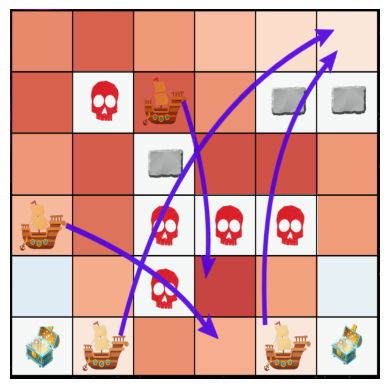

In [14]:
QTablePolicy4 = PolicyActionEvaluation(Policy=Policy4, DeterministicPolicy=False)
ValuePolicy4 = ValueFromQTable(QTablePolicy4, Policy4, DeterministicPolicy=False)
PlotPolicyValue(Policy4, ValuePolicy4, DeterministicPolicy=False)

# 3 Iterative policy improvement

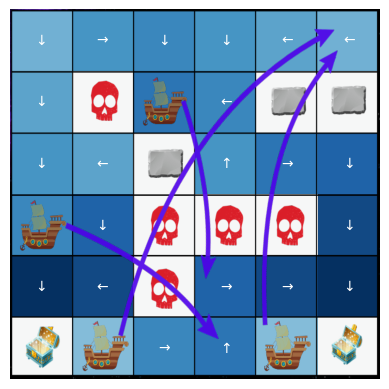

In [21]:
PolicyStar, ValueStar = PolicyIterativeEstimation(Policy4, DeterministicPolicy=False)
PolicyStar[EnvPirate=='boat'] = ''

PlotPolicyValue(PolicyStar, ValueStar)